In [21]:
import sys
main_dir = '../'
sys.path.append(main_dir)

import numpy as np
from scipy.optimize import minimize
from scipy.interpolate import interp1d

import opennu as on

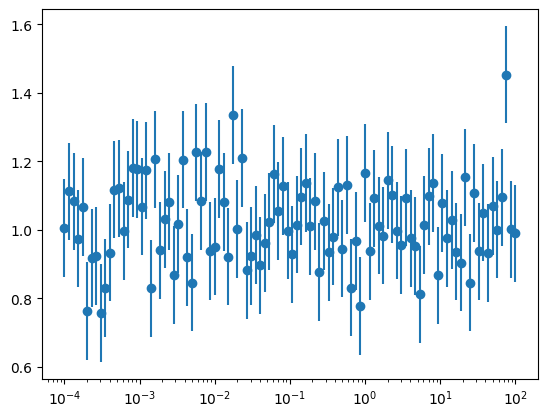

In [205]:
import numpy as np

N = 1e5                   # number of spins

#ratio = 3                # SQUID to SPN ratio from data
#NSQUID = N*ratio**2      # Effective number of spins due to SQUID noise


Nshots = 100              # Nshots
n_times = 100             # 
p_init_fixed = 1.0

t_exp = np.geomspace(1e-4, 100, n_times)

true_var = N / 4 #+ NSQUID/4

Jx_samples = np.random.normal(0, np.sqrt(true_var), size=(n_times, Nshots))
Jx2_exp = np.var(Jx_samples, axis=1, ddof=1)

# Uncertainty on sample variance (Var(s^2) = 2 * σ^4 / (M - 1))
sigma2 = (2 * true_var**2) / (Nshots - 1)
sigma = np.sqrt(sigma2) * np.ones(n_times)

plt.errorbar(t_exp, Jx2_exp/N*4, yerr=sigma/N*4, fmt='o', label='Synthetic variance data')
plt.xscale('log')
# plt.ylim(0.5, 1.5)

plt.show()

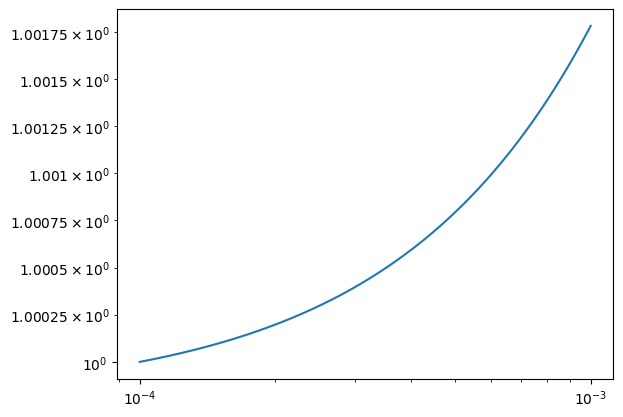

In [226]:
t2, _, _, jx2, _ = on.solve2nd(1e5, state='G',gp_ratio=0.99, gd_ratio=0, p_init=1, tf=0.001)
plt.loglog(t2, jx2/1e5*4)
plt.show()

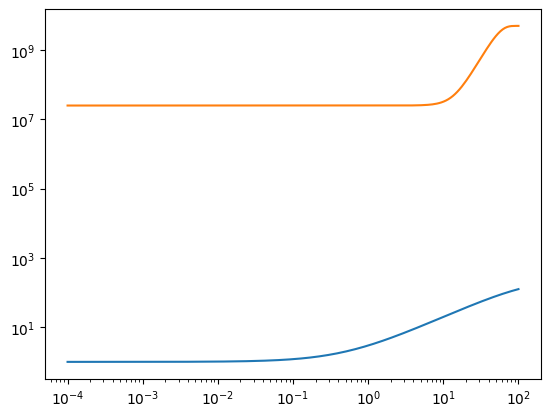

In [199]:
plt.semilogx(t2, model_Jx2(t2, 1, 0)/N*4)

t2, _, _, jx2, _ = on.solve2nd(N, state='G',gp_ratio=0.99,gd_ratio=0, tf=100, p_init=1)
plt.loglog(t2, j2)

In [201]:
N/4

25000.0

In [190]:
def model_Jx2(t_eval, p_init, de, gp_ratio=0.99):
    t_model, _, _, jx2, _ = on.solve2nd(N, state='G',
                                        gp_ratio=gp_ratio,
                                        gd_ratio=N*de,
                                        p_init=p_init,
                                        ti=min(t_eval)/1.1,
                                        tf=max(t_eval)*1.1)
    return interp1d(t_model, jx2, kind='cubic', bounds_error=False, fill_value='extrapolate')(t_eval)


In [113]:
def chi_squared(params, t_exp, Jx2_exp, sigma):
    p_init, de = params
    model_vals = model_Jx2(t_exp, p_init, de)
    return np.sum(((Jx2_exp - model_vals) / sigma)**2)

In [114]:
def chi_squared_fixed_p(de, t_exp, Jx2_exp, sigma, p_init_fixed=0.95):
    model_vals = model_Jx2(t_exp, p_init_fixed, de)
    return np.sum(((Jx2_exp - model_vals) / sigma)**2)

In [115]:
from scipy.optimize import minimize_scalar

res = minimize_scalar(chi_squared_fixed_p,
                      bounds=(1e-6, 1.0),
                      method='bounded',
                      args=(t_exp, Jx2_exp, sigma))

print(f"Best-fit de = {res.x}")
print(f"Minimum chi2 = {res.fun}")

Best-fit de = 0.9999933893328496
Minimum chi2 = 9097.12326606091


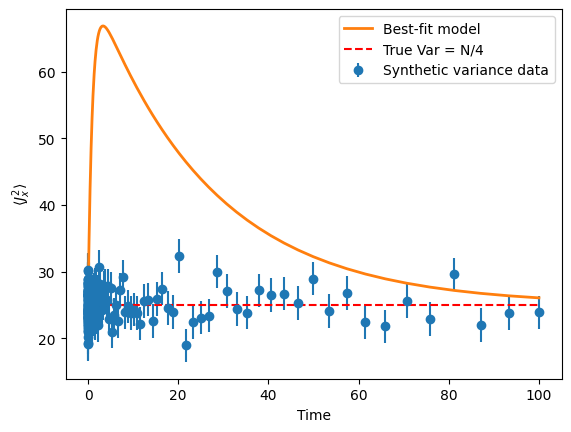

In [116]:
import matplotlib.pyplot as plt

plt.errorbar(t_exp, Jx2_exp, yerr=sigma, fmt='o', label='Synthetic variance data')
plt.plot(t_exp, model_Jx2(t_exp, p_init_fixed, res.x), label='Best-fit model', lw=2)
plt.hlines(true_var, t_exp[0], t_exp[-1], linestyle='--', color='r', label='True Var = N/4')
plt.xlabel("Time")
plt.ylabel(r"$\langle J_x^2 \rangle$")
plt.legend()
plt.show()


In [ ]:
# import matplotlib.pyplot as plt

# plt.errorbar(t_exp, Jx2_exp/N*4, yerr=sigma/N*4, fmt='o', label='Synthetic data')
# plt.plot(t_exp, model_Jx2(t_exp, res.x)/N*4, label='Best-fit model', lw=2)
# #plt.hlines(true_var/N*4, t_exp[0], t_exp[-1], color='r', linestyle='--', label='True variance')
# plt.xlabel('Time')
# plt.ylabel(r'$\langle J_x^2 \rangle$')
# plt.legend()
# plt.title('Synthetic variance data and model fit')
# plt.show()